In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error as mae

import warnings
warnings.filterwarnings('ignore')


In [24]:
df = pd.read_csv('boxoffice.csv',
				encoding='latin-1')
df.head()


,title,domestic_revenue,world_revenue,distributor,opening_revenue,opening_theaters,budget,MPAA,genres,release_days
0,Star Wars: Episode VIII - The Last Jedi,"$620,181,382","$1,332,539,889",Walt Disney Studios Motion Pictures,"$220,009,584","4,232","$317,000,000",PG-13,"Action,Adventure,Fantasy,Sci-Fi",382
1,The Fate of the Furious,"$226,008,385","$1,236,005,118",Universal Pictures,"$98,786,705","4,310","$250,000,000",PG-13,"Action,Adventure,Thriller",262
2,Wonder Woman,"$412,563,408","$821,847,012",Warner Bros.,"$103,251,471","4,165","$149,000,000",PG-13,"Action,Adventure,Fantasy,Sci-Fi,War",217
3,Guardians of the Galaxy Vol. 2,"$389,813,101","$863,756,051",Walt Disney Studios Motion Pictures,"$146,510,104","4,347","$200,000,000",PG-13,"Action,Adventure,Comedy,Sci-Fi",241
4,Beauty and the Beast,"$504,014,165","$1,263,521,126",Walt Disney Studios Motion Pictures,"$174,750,616","4,210","$160,000,000",PG,"Family,Fantasy,Musical,Romance",290


In [25]:
df.shape

(2694, 10)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2694 entries, 0 to 2693
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             2694 non-null   object
 1   domestic_revenue  2694 non-null   object
 2   world_revenue     2694 non-null   object
 3   distributor       2694 non-null   object
 4   opening_revenue   2390 non-null   object
 5   opening_theaters  2383 non-null   object
 6   budget            397 non-null    object
 7   MPAA              1225 non-null   object
 8   genres            2655 non-null   object
 9   release_days      2694 non-null   object
dtypes: object(10)
memory usage: 210.6+ KB


In [27]:
df.describe().T

,count,unique,top,freq
title,2694,2468,A Beautiful Planet,3
domestic_revenue,2694,2495,"$11,272,008",3
world_revenue,2694,2501,"$25,681,505",3
distributor,2694,248,Fathom Events,292
opening_revenue,2390,2176,"$4,696",3
opening_theaters,2383,732,1,503
budget,397,124,"$40,000,000",14
MPAA,1225,8,R,568
genres,2655,567,Documentary,351
release_days,2694,457,347,35


In [28]:
# We will be predicting only
# domestic_revenue in this article.

to_remove = ['world_revenue', 'opening_revenue']
df.drop(to_remove, axis=1, inplace=True)

In [29]:
df.isnull().sum() * 100 / df.shape[0]

title                0.000000
domestic_revenue     0.000000
distributor          0.000000
opening_theaters    11.544172
budget              85.263549
MPAA                54.528582
genres               1.447661
release_days         0.000000
dtype: float64

In [30]:
# Handling the null value columns
df.drop('budget', axis=1, inplace=True)

for col in ['MPAA', 'genres']:
	df[col] = df[col].fillna(df[col].mode()[0])

df.dropna(inplace=True)

df.isnull().sum().sum()

0

In [31]:
df['domestic_revenue'] = df['domestic_revenue'].str[1:]

for col in ['domestic_revenue', 'opening_theaters', 'release_days']:
	df[col] = df[col].str.replace(',', '')

	# Selecting rows with no null values
	# in the columns on which we are iterating.
	temp = (~df[col].isnull())
	df[temp][col] = df[temp][col].convert_dtypes(float)

	df[col] = pd.to_numeric(df[col], errors='coerce')

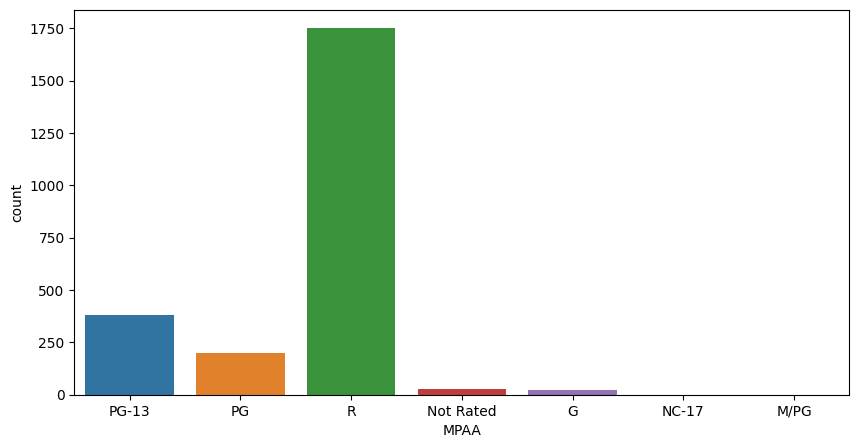

In [33]:
plt.figure(figsize=(10, 5))
sb.countplot(data=df, x='MPAA')
plt.show()

In [35]:
df.groupby('MPAA').mean()['domestic_revenue']

TypeError: Could not convert To the Arctic 3DJourney to the South PacificAmazing GraceDeep SeaJourney to the South PacificTo the Arctic 3DDeep SeaThe Cat ReturnsPeppa Celebrates Chinese New YearDeep SeaPandasTo the Arctic 3DTrue GritEarth: One Amazing DayStar Trek: The Motion PictureMy Fair LadyJourney to the South PacificPandasAmazing GracePenguinsApollo 11Born in ChinaToy Story 4Cars 3 to numeric

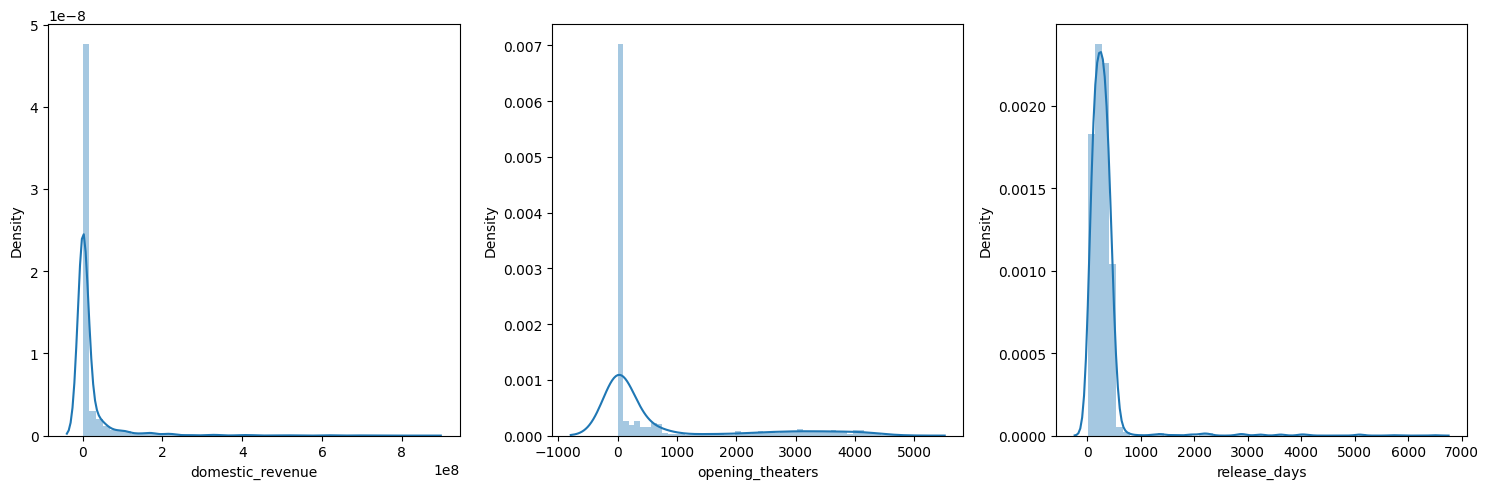

In [36]:
plt.subplots(figsize=(15, 5))

features = ['domestic_revenue', 'opening_theaters', 'release_days']
for i, col in enumerate(features):
	plt.subplot(1, 3, i+1)
	sb.distplot(df[col])
plt.tight_layout()
plt.show()

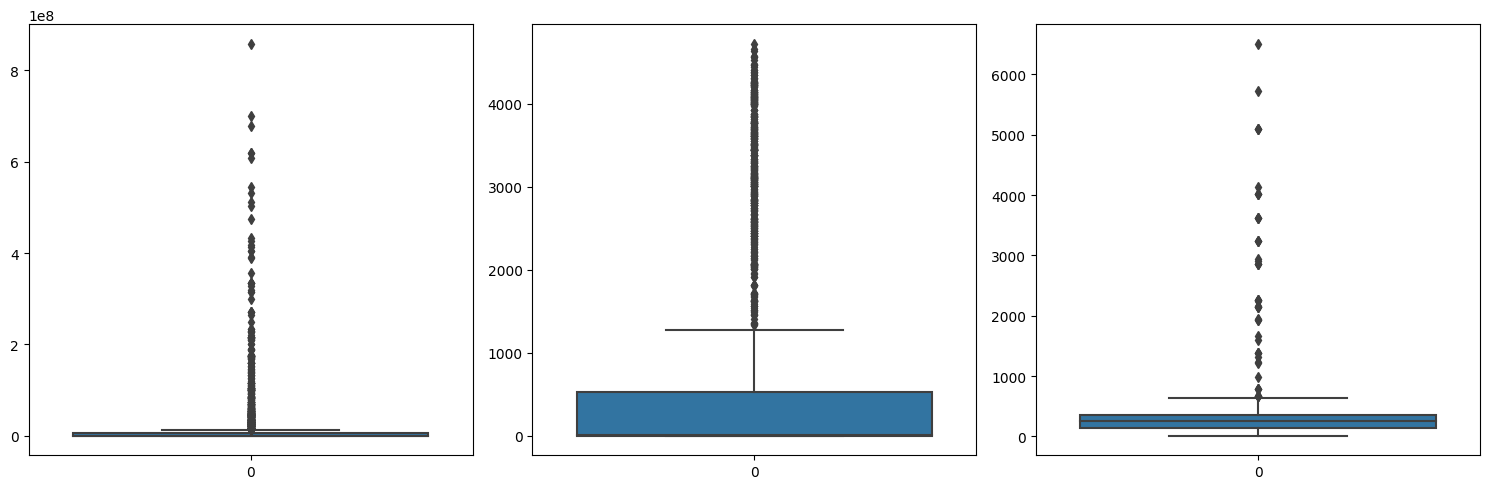

In [37]:
plt.subplots(figsize=(15, 5))
for i, col in enumerate(features):
	plt.subplot(1, 3, i+1)
	sb.boxplot(df[col])
plt.tight_layout()
plt.show()

In [39]:
for col in features:
    df[col] = df[col].apply(lambda x: np.log10(x))

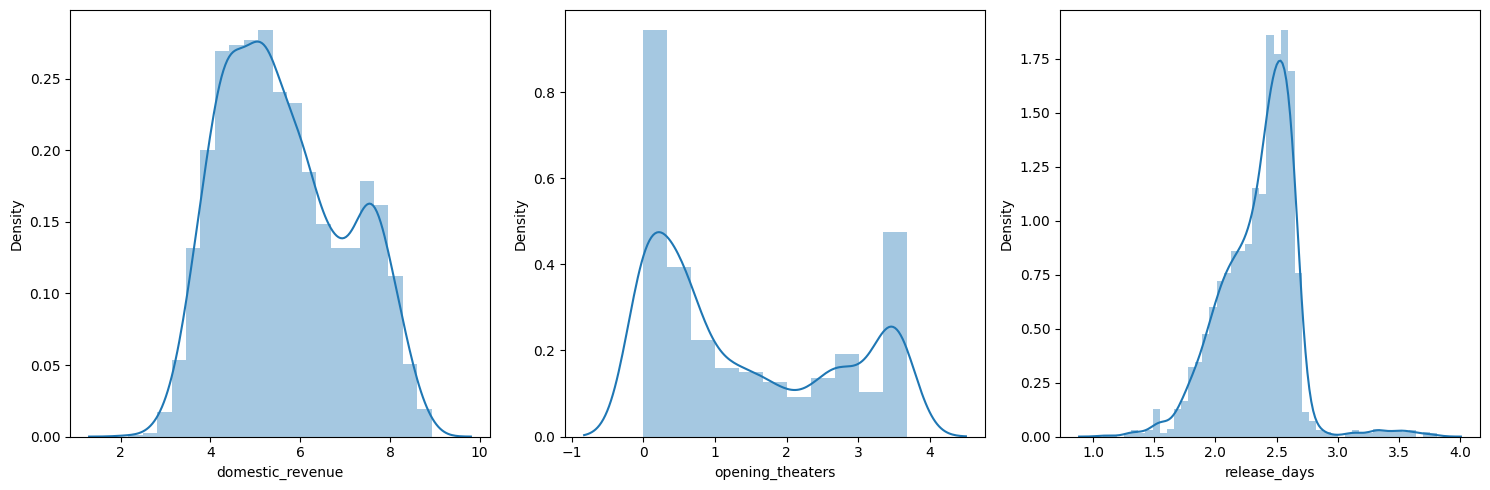

In [40]:
plt.subplots(figsize=(15, 5))
for i, col in enumerate(features):
	plt.subplot(1, 3, i+1)
	sb.distplot(df[col])
plt.tight_layout()
plt.show()

In [42]:
from sklearn.feature_extraction.text import CountVectorizer

# Create and fit the CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(df['genres'])

# Transform the genres column
features = vectorizer.transform(df['genres']).toarray()

# Get the feature names
feature_names = vectorizer.get_feature_names_out()

# Add the features to your DataFrame
for i, name in enumerate(feature_names):
    df[name] = features[:, i]

In [44]:
vectorizer = CountVectorizer()
vectorizer.fit(df['genres'])
features = vectorizer.transform(df['genres']).toarray()

genres = vectorizer.get_feature_names_out()
for i, name in enumerate(genres):
	df[name] = features[:, i]

df.drop('genres', axis=1, inplace=True)

In [45]:
removed = 0
for col in df.loc[:, 'action':'western'].columns:

	# Removing columns having more
	# than 95% of the values as zero.
	if (df[col] == 0).mean() > 0.95:
		removed += 1
		df.drop(col, axis=1, inplace=True)

print(removed)
print(df.shape)

11
(2383, 24)


In [46]:
for col in ['distributor', 'MPAA']:
	le = LabelEncoder()
	df[col] = le.fit_transform(df[col])

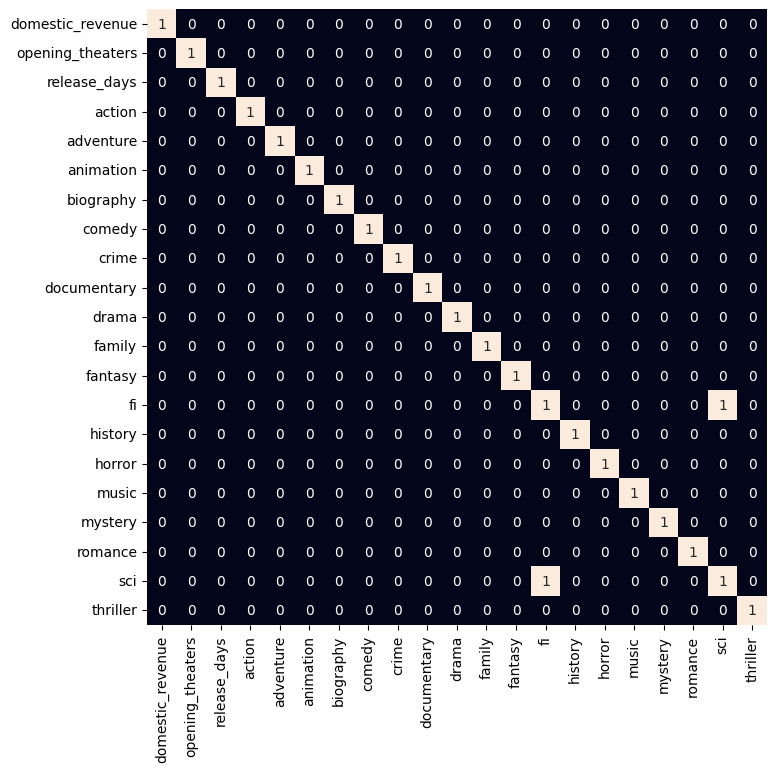

In [49]:
# Assuming you have a list of non-numeric column names to exclude
non_numeric_columns = ['title', 'distributor', 'MPAA']

# Select only numeric columns
numeric_columns = df.drop(columns=non_numeric_columns)

# Calculate the correlation matrix for numeric columns
correlation_matrix = numeric_columns.corr()

# Create a heatmap
plt.figure(figsize=(8, 8))
sb.heatmap(correlation_matrix > 0.8, annot=True, cbar=False)
plt.show()

In [51]:
features = df.drop(['title', 'domestic_revenue', 'fi'], axis=1)
target = df['domestic_revenue'].values

X_train, X_val,\
	Y_train, Y_val = train_test_split(features, target,
									test_size=0.1,
									random_state=22)
X_train.shape, X_val.shape

((2144, 21), (239, 21))

In [52]:
# Normalizing the features for stable and fast training.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [60]:
model = XGBRegressor()
model.fit(X_train, Y_train)
# Make predictions on the training and validation data
train_preds = model.predict(X_train)
print('Training Error : ', mae(Y_train, train_preds))

val_preds = model.predict(X_val)
# Continue with your validation and testing logic
print('Validation Error : ', mae(Y_val, val_preds))
print()

Training Error :  0.13244736533748125
Validation Error :  0.42306483705722453

